# Predicting the next closing price of the S&P500

This notebook aims to estimate the next closing price of the S&P500 using only technical information that is available on a candlestick chart today.

The initial motivation is to test the hypothesis that the next candlestick can be approximated by the candlestick before. However, this proved to be somewhat beyond my current understanding of a multi-dependent variable estimation model.

As such I decided to simplify the problem by predicting only the next closing price instead of the entire candlestick.

## Disclaimer

** The contents, estimations, and predictions in this notebook is meant solely for research and educational purposes (mostly for my own learning) and should not be taken as investment advice. Neither the author nor anyone else distributing this notebook is liable for any losses that occur from using the information in this notebook. **

## Rationale

When traders employ technical analysis, the key information they look at to derive buy or sell signals are the patterns of the candlestick formations. These patterns are defined and recognised by looking at the lengths of each portion of a candlestick relative to the other parts (eg. evening star, morning star, marubozu, dojis, spinning tops, hammers etc).

The buy and sell signals are further enhanced by looking at candlestick patterns preceding the current one, both independently and as combinations.

However, how can we confirm that these pre-defined candlestick patterns are supposed to work as they are intended to? We may be wrong from the start.

As such, instead of manually identifying the candlestick formations based on prior knowledge obtained from various republished sources, we will let the model explore the data and form its own patterns. (eg. imagine a whole new set of stars, marubozus, dojis, tops, hammers etc)

For a start, I will only be using 1 candlestick to predict the next candlestick. I will incrementally add prior days once I get the hang of it.

## Assumptions

1) All fundamental information are already incorporated in the price <br>


2) Prices are driven entirely by price action in a continuous and simultaneous game, where investors can observe each other's moves before making their own move, or initiate a move to pre-empt the moves of others <br>


3) New news releases that have a significant impact may still move prices beyond the prediction capabilities of the model

## Methodology

I will be downloading the full historical price data of the S&P 500 from Yahoo Finance.

This dataset comes with the **Date, Open, High, Low, Close, Adj, Close, Volume** features.

I will further engineer 10 new features from the candlestick data available, these will be as follows:

1) **bodyLength** - This is derived as **Open** minus **Close**. The body length of a candle shows the magnitude of the buying/selling pressure <br>

2) **upperWick** - This is derived as **High** minus **Open/Close** depending on the 'colour' of the candlestick. The upper wick length of a candlestick represents the extent of profit-taking during the day <br>

3) **lowerWick** - This is derived as **Low** minus **Open/Close** depending on the 'colour' of the candlestick. The lower wick length of a candlestick represents the extent of bulls-buying-the-dip <br>

4) **CandleLength** - This is derived as **High** minus **Low**. The total candle length indicates the overall price movement during the day. Shorter lengths signifies consolidation and longer lengths signifies volatility. <br>

5) **body%** - This is derived as **bodyLength/candleLength**. Similar to **body** the ratio of a candlestick's body to its total length shows the magnitude of buying/selling pressure, with an additional data point of being relative to its total candle length. <br>

6) **lowerWick%** - This is derived as **lowerWick/candleLength**. Similar to **lowerWick** the ratio of a candlestick's lower wick to its total length shows the magnitude of profit-taking, with an additional data point of being relative to its total candle length. <br>

7) **upperWick%** - This is derived as **upperWick/candleLength**. Similar to **lowerWick** the ratio of a candlestick's upper wick to its total length shows the magnitude of bulls-buying-the-dip, with an additional data point of being relative to its total candle length. <br>

8) **lower/upper** - This is derived as **lowerWick/upperWick**. The ratio of the length of a candlesticks lower wick to its upper wick shows how much profit-taking there is compared to bulls-buying-the-dip <br>

9) **lower/body** - This is derived as **lowerWick/bodyLength**. The ratio of the length of a candlesticks lower wick to its body length shows how much bulls-buying-the-dip there is compared to the price range where most of the trading activity occurs. Supposedly, when this ratio is high, the chances of an uptrend increases substantially <br>

10) **upper/body** - This is derived as **upperWick/bodyLength**. The ratio of the length of a candlesticks upper wick to its body length shows how much profit-taking there is compared to the price range where most of the trading activity occurs. Supposedly, when this ratio is high, the chances of an downtrend increases substantially 

In [1]:
# Import the basic data wrangling libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Load the dataset
df_pre = pd.read_csv('^GSPC.csv')

In [3]:
# Preview the dataset
df_pre.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000
1,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000
2,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000
3,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000
4,1950-01-09,17.09,17.09,17.08,17.08,17.08,3850000


In [4]:
df_pre.shape

(17013, 7)

In [5]:
# Add new data as a comment here for reference
## Aug 14, 2017	2,454.96	2,468.22	2,454.96	2,465.84	2,465.84	2,822,550,000

In [6]:
# Add new data each day here in the format of (index, {:})
data = []

data.insert(17013, {'Date': '14-Aug-17', 'Open': 2454.96, 'High': 2468.22, 'Low': 2454.96, 'Close': 2465.84, 'Adj Close': 2465.84,
                    'Volume': 2822550000})

df = pd.concat([pd.DataFrame(data), df_pre], ignore_index=True)
''' There is a bug in the pandas library that automatically assigns new rows created at index=0 
and re-sorts the columns accordingalphabetical order. We will have to deal with this below.'''

' There is a bug in the pandas library that automatically assigns new rows created at index=0 \nand re-sorts the columns accordingalphabetical order. We will have to deal with this below.'

In [7]:
# Creating a new row at the bottom-most index and assign it to the same value as the first (new) row
df.loc[17104] = df.loc[0]

In [8]:
# Check out the last row
df.loc[17104]

Adj Close       2465.84
Close           2465.84
Date          14-Aug-17
High            2468.22
Low             2454.96
Open            2454.96
Volume       2822550000
Name: 17104, dtype: object

In [9]:
# Drop the first row
df.drop(0, axis=0, inplace=True)

In [10]:
# Reset the index as it now starts from '1' instead of '0'
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [11]:
# Resort the columns
cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df = df[cols]

In [12]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000
1,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000
2,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000
3,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000
4,1950-01-09,17.09,17.09,17.08,17.08,17.08,3850000


Perfect. On to the pre-processing phase.

In [13]:
df['bodyLength'] = (df['Close'] - df['Open'])/df['Open']

In [14]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,bodyLength
0,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000,0.000000
1,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000,0.000000
2,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000,0.000000
3,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000,0.000000
4,1950-01-09,17.09,17.09,17.08,17.08,17.08,3850000,-0.000585


In [15]:
tempList = []

for i, value in enumerate(df['bodyLength']):
    if value > 0:
        upperWick = (df['High'][i] - df['Close'][i])/df['Open'][i]
    else:
        upperWick = (df['High'][i] - df['Open'][i])/df['Open'][i]
    
    tempList.append(upperWick)

In [16]:
df['upperWick'] = tempList

In [17]:
tempList = []

for i, value in enumerate(df['bodyLength']):
    if value > 0:
        lowerWick = (df['Open'][i] - df['Low'][i])/df['Open'][i]
    else:
        lowerWick = (df['Close'][i] - df['Close'][i])/df['Open'][i]
    
    tempList.append(lowerWick)

In [18]:
df['lowerWick'] = tempList

In [19]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,bodyLength,upperWick,lowerWick
17009,2017-08-08,2478.350098,2490.870117,2470.320068,2474.919922,2474.919922,3344640000,-0.001384,0.005052,0.000000
17010,2017-08-09,2465.350098,2474.409912,2462.080078,2474.020020,2474.020020,3308060000,0.003517,0.000158,0.001326
17011,2017-08-10,2465.379883,2465.379883,2437.750000,2438.209961,2438.209961,3621070000,-0.011021,0.000000,0.000000
17012,2017-08-11,2441.040039,2448.090088,2437.850098,2441.320068,2441.320068,3159930000,0.000115,0.002773,0.001307
17013,14-Aug-17,2454.960000,2468.220000,2454.960000,2465.840000,2465.840000,2822550000,0.004432,0.000969,0.000000


In [20]:
df['candleLength'] = (df['High'] - df['Low'])/df['Open']

In [21]:
df['body%'] = df['bodyLength']/df['candleLength']
df['lowerWick%'] = abs(df['lowerWick'])/df['candleLength']
df['upperWick%'] = df['upperWick']/df['candleLength']
df['lower/upper'] = df['lowerWick%']/df['upperWick%']
df['lower/body'] = df['lowerWick%']/df['body%']
df['upper/body'] = df['upperWick%']/df['body%']

Now that we have all our newly engineered features ready, its time to deal with the null and infinity values

In [22]:
# Check which columns have null values and how many are there
df.isnull().sum()

Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
bodyLength         0
upperWick          0
lowerWick          0
candleLength       0
body%           2968
lowerWick%      2968
upperWick%      2968
lower/upper     4534
lower/body      3021
upper/body      2969
dtype: int64

Seems like 6 out of 10 of our new features have null values. These values are caused by the numerator being equal to 0.
#### 0 divided by anything (including 0) will return a NaN value.

In [23]:
# Lets have a clearer picture
df[df['body%'].isnull()==True]


,Date,Open,High,Low,Close,Adj Close,Volume,bodyLength,upperWick,lowerWick,candleLength,body%,lowerWick%,upperWick%,lower/upper,lower/body,upper/body
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,16.660000,1260000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,16.850000,1890000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,16.930000,2550000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,16.980000,2010000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1950-01-10,17.030001,17.030001,17.030001,17.030001,17.030001,2160000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6,1950-01-11,17.090000,17.090000,17.090000,17.090000,17.090000,2630000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,1950-01-12,16.760000,16.760000,16.760000,16.760000,16.760000,2970000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8,1950-01-13,16.670000,16.670000,16.670000,16.670000,16.670000,3330000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
10,1950-01-17,16.860001,16.860001,16.860001,16.860001,16.860001,1790000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11,1950-01-18,16.850000,16.850000,16.850000,16.850000,16.850000,1570000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# We will first replace all NaN values with 0
df.fillna(0, inplace=True)

Next we will deal with the infinity and -infinity values by replacing them with the maximum value within that feature
#### Infinity values occur when numbers other than 0 are divided by 0

In [25]:
# First we will have to convert these values to NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [26]:
# Check out where were the infinity values located at
df.isnull().sum()

Date              0
Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
bodyLength        0
upperWick         0
lowerWick         0
candleLength      0
body%             0
lowerWick%        0
upperWick%        0
lower/upper     410
lower/body        0
upper/body       52
dtype: int64

In [27]:
# Now lets check out what are the max values for 'lower/upper' and 'upper/body'
print(df['lower/upper'].max())
print(df['upper/body'].max())

1472.64680892
753.522200857


In [28]:
# Replace the null values in 'lower/upper'
tempValue = df['lower/upper'].max()
df['lower/upper'].fillna(tempValue, inplace=True)

In [29]:
# Replace the null values in 'upper/body'
tempValue = df['upper/body'].max()
df['upper/body'].fillna(tempValue, inplace=True)

In [30]:
# Lets check our results
df.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
bodyLength      0
upperWick       0
lowerWick       0
candleLength    0
body%           0
lowerWick%      0
upperWick%      0
lower/upper     0
lower/body      0
upper/body      0
dtype: int64

Perfect. Time to move on to assigning labels to each day's data.

Recall the methodology is to only use the information available today to predict the closing price for tomorrow's candle.

We will use Close(d+1) as the label for Xi(d).

In [31]:
# Recall the number of samples available
df.shape

(17014, 17)

We need an algorithm to assign the labels from d+1 into each day.

In [32]:
tempList = []

for i, price in enumerate(df['Close']):
    if i < 17013:
        d1 = df['Close'][i+1]
        tempList.append(d1)
tempList.append(0)

In [33]:
len(tempList)

17014

In [34]:
tempList[-5:]

[2474.0200199999999, 2438.209961, 2441.320068, 2465.8400000000001, 0]

In [35]:
# Create a new column in df for the labels
df['Close_d+1'] = tempList

In [36]:
# Drop the latest row cos we dont know tomorrow's closing price yet
df_clean = df.drop(17013)

In [37]:
# Create the features set and labels set
feat_df = df_clean[df_clean.drop(['Date', 'Adj Close', 'Close_d+1'], axis=1).columns] # we dont need the date, 'Adj Close' and 'Close_d+1' columns
label_df = df_clean['Close_d+1']

In [38]:
feat_df.head()

,Open,High,Low,Close,Volume,bodyLength,upperWick,lowerWick,candleLength,body%,lowerWick%,upperWick%,lower/upper,lower/body,upper/body
0,16.66,16.66,16.66,16.66,1260000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,16.85,16.85,16.85,16.85,1890000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,16.93,16.93,16.93,16.93,2550000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,16.98,16.98,16.98,16.98,2010000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,17.09,17.09,17.08,17.08,3850000,-0.000585,0.0,0.0,0.000585,-1.0,0.0,0.0,0.0,-0.0,-0.0


In [39]:
label_df.head()

0    16.850000
1    16.930000
2    16.980000
3    17.080000
4    17.030001
Name: Close_d+1, dtype: float64

In [40]:
feat_df.shape

(17013, 15)

In [41]:
label_df.shape

(17013,)

In [42]:
# Assign training variables

X = feat_df
y = label_df

Time to split the samples into training and testing data

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

The **Random Forest** algorithm should be a quick and dirty way to uncover any hidden relationship between today's information and tomorrow's closing price

Recall that some advantages of the **Random Forest** algorithm is that it:

- **Reduces overfitting**: by averaging several trees, there is a significantly lower risk of overfitting <br>


- Has **less variance**: By using multiple trees, you reduce the chance of stumbling across a classifier that doesn’t perform well because of the relationship between the train and test data <br>


- Is **Non-parametric**: Non-parametric models enable us to forego any assumptions about the distribution of the features and simply let the model learn the associations between the features and label. This allows us to skip the tests for skewness of each feature and the log-transformation step <br>


- **Mitigates multi-colinearity**: Co-linearity saps the statistical power of our model by making it difficult to identify the importance of each variable (feature) <br>


The trade-off is that it takes a hell lot of time to train.

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [78]:
params_grid = {'n_estimators': [10, 50, 100, 200, 300, 400, 500]}

In [79]:
# grid = GridSearchCV(RandomForestRegressor(), param_grid=params_grid, verbose=2, cv=5)

In [80]:
# grid.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   1.2s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] .................................. n_estimators=10, total=   1.2s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   1.2s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   1.3s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   1.3s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   6.0s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   6.7s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   6.0s
[CV] n_estimators=50 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 17.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 200, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

Phew, finally done. Lets check out our best estimators.

In [81]:
grid.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

The 300 tree version performs best.

Prediction time! Fingers crossed!

In [205]:
predictions = grid.predict(X_test)

In [295]:
predictions_df = pd.DataFrame(predictions)

In [296]:
predictions_df.head()

,0
0,99.146667
1,48.098100
2,1184.403138
3,467.609166
4,275.175932


In [297]:
# Rename the Column
predictions_df.columns = ['Predicted Close']

In [298]:
predictions_df.head()

,Predicted Close
0,99.146667
1,48.098100
2,1184.403138
3,467.609166
4,275.175932


In [299]:
# Realign the sample number on the index. This will enable us to track which pair each prediction belongs to
predictions_df.index = y_test.index

In [300]:
predictions_df.head()

,Predicted Close
5391,99.146667
1592,48.098100
15178,1184.403138
11335,467.609166
9790,275.175932


In [301]:
y_test_df = pd.DataFrame(y_test, index=y_test.index)

In [302]:
y_test_df.columns = ['Close']

In [214]:
y_test_df.head()

,Close
5391,99.279999
1592,47.160000
15178,1202.260010
11335,468.320007
9790,274.279999


In [215]:
results = predictions - y_test

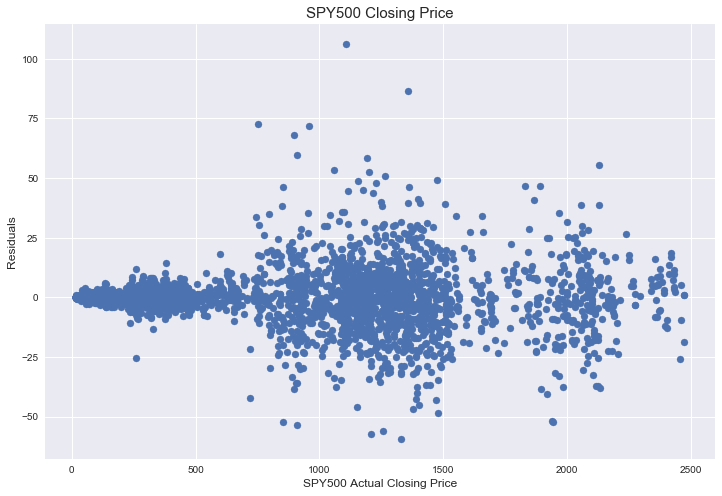

In [236]:
plt.figure(figsize=[12, 8])
plt.scatter(y_test, results)
plt.xlabel('SPY500 Actual Closing Price', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('SPY500 Closing Price Prediction Residuals Plot', fontsize=15)

We can see some heteroscedasticity beyond the 750 closing price onward. Hmm how do they deal with this again? Probably passing a log function through? Will need to revisit the dataset and do some more pre-processing.

In [238]:
results.describe()

count    5615.000000
mean       -0.099305
std         8.806913
min       -59.399162
25%        -0.906135
50%        -0.017534
75%         0.855852
max       106.347032
Name: Close_d+1, dtype: float64

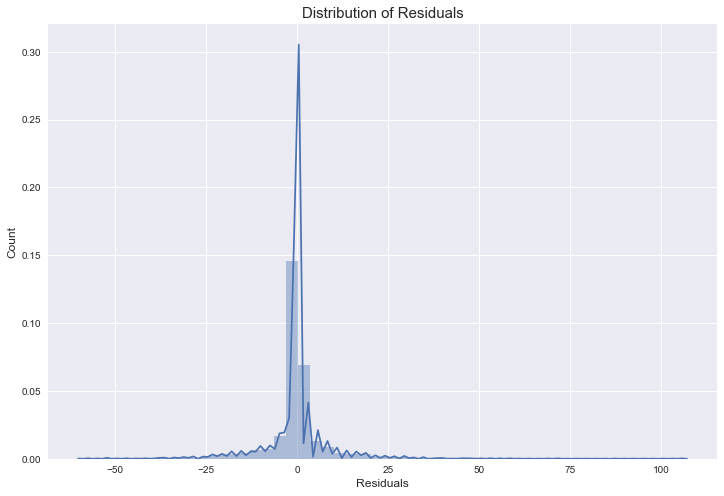

In [239]:
plt.figure(figsize=[12, 8])
sns.distplot(results)
plt.title('Distribution of Residuals', fontsize=15)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Count', fontsize=12)

Not sure if this extreme kurtosis is good or bad. Either we found Eldorado or something is wrong with our experiment setup.

Lets check out the usual regression metrics to further assess the performance of our model

In [222]:
# Call the mean-squared error, mean-absolute error, and root-mean-squared error functions
from sklearn import metrics

In [223]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 4.16830411522
MSE: 77.5577696974
RMSE: 8.80668891794


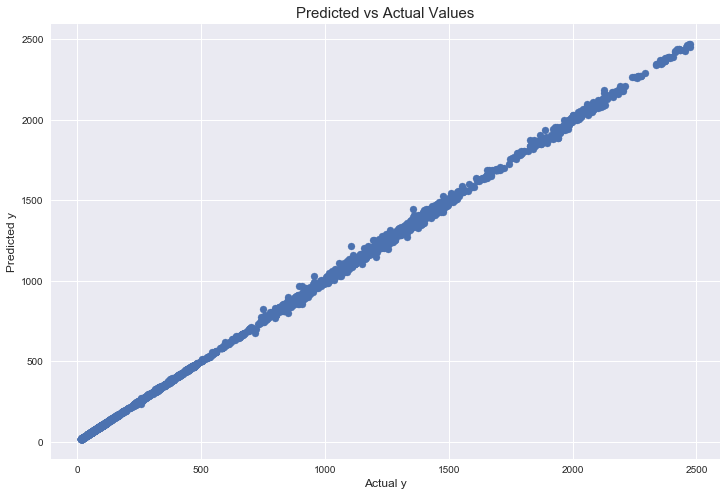

In [231]:
# Plot the predicted values against the test values
plt.figure(figsize=[12, 8])
plt.scatter(y_test, predictions)
plt.xlabel('Actual y', fontsize=12)
plt.ylabel('Predicted y', fontsize=12)
plt.title('Predicted vs Actual Values', fontsize=15)

wait.. what?

This is highly suspiscious. We have seen on top that our residuals are highly centered around 0 with an unusually sharp peak.

Now lets attempt to put the scale of error into perspective. I will be expressing the residuals as a percentage of the actual closing price scaled up 100 times.

In [225]:
# Check out how our error rates vary over different closing price values
predictions_df['Actual'] = y_test.values
predictions_df.columns = ['Predicted SPY500 Closing Price', 'Actual SPY500 Closing Price']
predictions_df['Error%'] = (((predictions_df['Predicted SPY500 Closing Price'] - 
                           predictions_df['Actual SPY500 Closing Price'])/
                           predictions_df['Actual SPY500 Closing Price'])*100)
predictions_df.head()

,Predicted SPY500 Closing Price,Actual SPY500 Closing Price,Error%
5391,99.146667,99.279999,-0.134299
1592,48.098100,47.160000,1.989187
15178,1184.403138,1202.260010,-1.485275
11335,467.609166,468.320007,-0.151785
9790,275.175932,274.279999,0.326649


In [226]:
# Overview of the error rate
predictions_df['Error%'].describe()

count    5615.000000
mean       -0.003238
std         1.039645
min        -9.840894
25%        -0.534614
50%        -0.014628
75%         0.502991
max         9.629100
Name: Error%, dtype: float64

If I remember my statistics 101 right, our error values are almost exactly normally distributed, which means our residuals should be reliable. Lets confirm that again later.

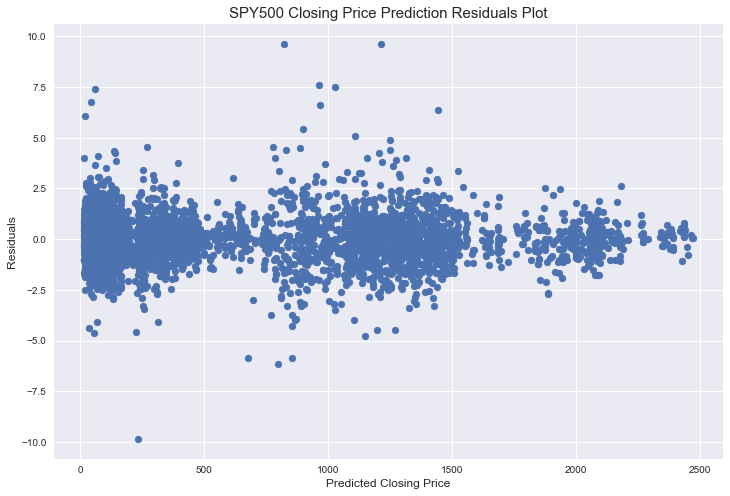

In [246]:
# Check out the new scaled-up residuals plot
plt.figure(figsize=[12, 8])
plt.scatter(predictions_df['Predicted SPY500 Closing Price'], predictions_df['Error%'])
plt.title('SPY500 Closing Price Prediction Residuals Plot', fontsize=15)
plt.xlabel('Predicted Closing Price', fontsize=12)
plt.ylabel('Residuals', fontsize=12)

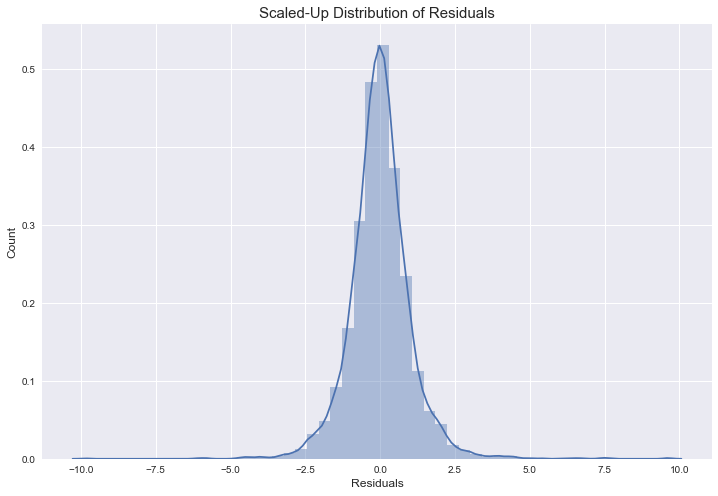

In [247]:
# Check out the distribution of the new scaled-up residuals
plt.figure(figsize=[12, 8])
sns.distplot(predictions_df['Error%'])
plt.title('Scaled-Up Distribution of Residuals', fontsize=15)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Count', fontsize=12)

As expected it looks more 'normal' now.

Finally lets check out the coefficients to identify the importance of each feature. We will have to refit the training data using a new RandomForestRegressor() instance in order to call the **feature importances** function.

We will do this with the parameters found by GridSearchCV (ie. 300 trees)

In [47]:
# Instantiate the Random Forest Regressor algorithm
forest = RandomForestRegressor(n_estimators=300, oob_score=True, verbose=2)

In [48]:
# Fit the train data into forest
forest.fit(X_train, y_train)

building tree 1 of 300
building tree 2 of 300


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   33.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=True, random_state=None,
           verbose=2, warm_start=False)

In [49]:
# Check out the coefficients
coef = forest.feature_importances_.tolist()
coef_df = pd.DataFrame(coef, columns=['Coefficient'], index=feat_df.columns)
coef_df

,Coefficient
Open,0.028933
High,0.401047
Low,0.105639
Close,0.464280
Volume,0.000020
bodyLength,0.000012
upperWick,0.000014
lowerWick,0.000005
candleLength,0.000014
body%,0.000011


Well, what we you know. Seems like our newly engineered features mean little to nothing at all in terms of predicting the next closing price and that the most important features are the **Close** and the **High** of the day. It is also quite surprising to see that **Volume** plays almost no role in the next day's closing price.

This could either mean one or more of the following: 

1) The experiment setup was wrong from the start <br>


2) Using only candlestick pattern data from the previous day is insufficient and insignificant when compared to the basic candlestick metrics (high, low, open, close) <br>


3) Candlestick patterns are as effective as mysticism <br>


More exploration is definitely needed and these coefficient weights should probably not be generalised outside of the S&P 500 data.

In summary, our model is performing ridiculously well for an out-of-the-box approach. This should be a sign of either overfitting or using an inaccurate scale for comparison. Anyway, lets call our model Alfred and finish this run for now.

In [229]:
# Revisit the last few entries of the dataset
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,bodyLength,upperWick,lowerWick,candleLength,body%,lowerWick%,upperWick%,lower/upper,lower/body,upper/body,Close_d+1
17009,2017-08-08,2478.350098,2490.870117,2470.320068,2474.919922,2474.919922,3344640000,-0.001384,0.005052,0.000000,0.008292,-0.166918,0.000000,0.609245,0.000000,-0.000000,-3.649964,2474.020020
17010,2017-08-09,2465.350098,2474.409912,2462.080078,2474.020020,2474.020020,3308060000,0.003517,0.000158,0.001326,0.005001,0.703166,0.265212,0.031622,8.386989,0.377168,0.044971,2438.209961
17011,2017-08-10,2465.379883,2465.379883,2437.750000,2438.209961,2438.209961,3621070000,-0.011021,0.000000,0.000000,0.011207,-0.983353,0.000000,0.000000,0.000000,-0.000000,-0.000000,2441.320068
17012,2017-08-11,2441.040039,2448.090088,2437.850098,2441.320068,2441.320068,3159930000,0.000115,0.002773,0.001307,0.004195,0.027347,0.311518,0.661135,0.471186,11.391467,24.176139,2465.840000
17013,14-Aug-17,2454.960000,2468.220000,2454.960000,2465.840000,2465.840000,2822550000,0.004432,0.000969,0.000000,0.005401,0.820513,0.000000,0.179487,0.000000,0.000000,0.218750,0.000000


Alright Alfred, time for a test - What is the closing price for SPY500 yesterday?

In [195]:
grid.predict(df[df.drop(['Date', 'Close_d+1'], axis=1).columns].loc[17012])

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 2452.66904633])

The actual closing price for SPY500 yesterday was 2465.84 - Making Alfred wrong by around 0.54%, which is quite a lot for a market index. We will have to revise our model, probably using returns as the dependent variable instead of price.

The rationale being that at very high prices and little volatility due to it being a perfectly diversified market index, the variations in price will be miniscule. Hence our residuals will always be very close to 0 as long as our predictions are close to a simple mean regression line.

Well in the meantime lets predict the closing price for tomorrow 15/08/17 since we are at it. We will have to monitor our predictions daily for the next few weeks.

In [191]:
# Predict today's closing price!
grid.predict(df[df.drop(['Date', 'Close_d+1'], axis=1).columns].loc[17013])

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 2454.3024181])

#### 2454.30 for 15/08/17 We shall see.

Please feel free to leave your comments!